In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
from itertools import product

from skimage import io, color, exposure, transform, img_as_float32
import skimage
from sklearn import preprocessing

from dask import bag, diagnostics
from scipy import stats

from pathlib import Path
import os, sys

sys.path.insert(0, str(Path.cwd().parent))
import leukopy_lib as leuko
from importlib import reload
reload(leuko)

import umap
import umap.plot

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Import normal peripheral blood cell dataset

In [4]:
path_name = '../../data/PBC_dataset_normal_df.csv'
path = Path(path_name)
df = pd.read_csv(path_name)
df.head()

img_paths      id label cell_type  \
0  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  225079    MO  monocyte   
1  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  582430    MO  monocyte   
2  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  436409    MO  monocyte   
3  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  648815    MO  monocyte   
4  ../../data/PBC_dataset_normal_DIB/monocyte/MO_...  668574    MO  monocyte   

   height  width  mean_brightness  mean_luminance  
0     363    360       196.225564        0.756902  
1     363    360       196.672727        0.757366  
2     363    360       204.348235        0.797640  
3     363    360       199.038259        0.770929  
4     363    360       191.020018        0.734784

In [5]:
classes = df['label'].unique()
classes

array(['MO', 'ERB', 'PLT', 'BA', 'NEU', 'LY', 'EO', 'IG'], dtype=object)

In [24]:
le = preprocessing.LabelEncoder()
target = le.fit_transform(df.cell_type)
le.classes_

array(['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte',
       'monocyte', 'neutrophil', 'platelet'], dtype=object)

## Import images and store as an array of arrays

In [8]:
dfile_bag = bag.from_sequence(df.img_paths.to_list()).map(leuko.load_image, 
                                                          as_grey=True, 
                                                          rescale=0.5)

In [9]:
with diagnostics.ProgressBar():
    images = np.array(dfile_bag.compute())


[########################################] | 100% Completed |  2min 20.5s


In [10]:
images_flat = images.reshape(images.shape[0], -1)

### UMAP embedding in 2D

In [11]:
%%time
mapper = umap.UMAP(n_neighbors=5, random_state=42, n_jobs=6).fit(images_flat)
embedding = mapper.transform(images_flat)

CPU times: user 4min 29s, sys: 7.43 s, total: 4min 36s
Wall time: 1min 18s


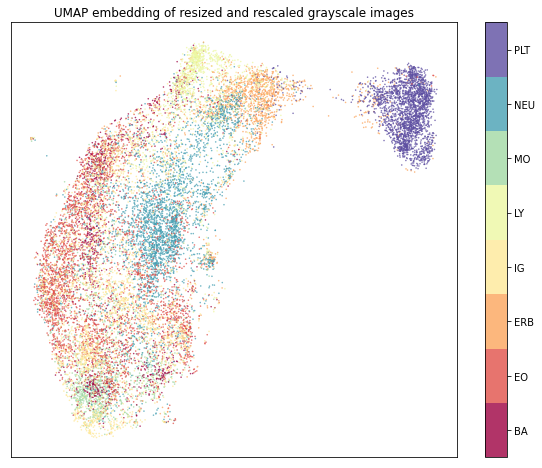

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding.T, s=0.3, c=target, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(le.classes_)
plt.title('UMAP embedding of resized and rescaled grayscale images');



<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

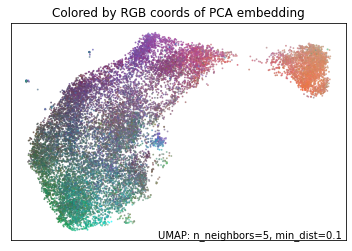

In [13]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

<AxesSubplot:>

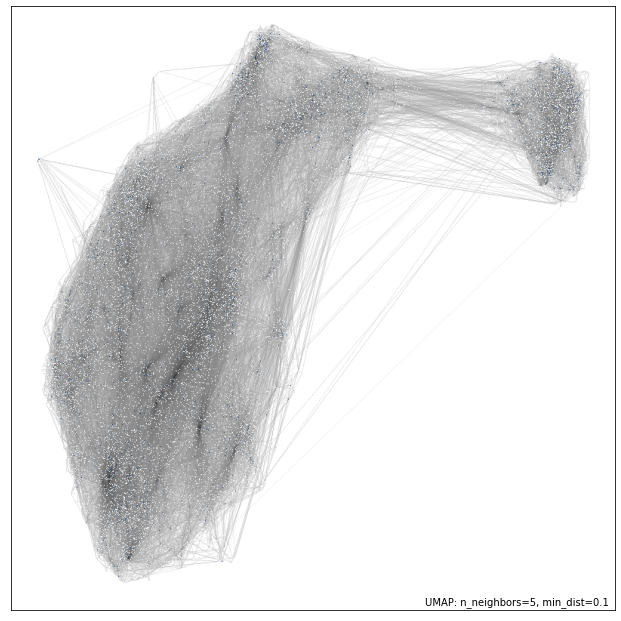

In [14]:
umap.plot.connectivity(mapper, show_points=True)

# Plotting connectivity and images for small sample

In [15]:
sample = df.groupby('label').sample(n=400)
sample.label.value_counts()

IG     400
PLT    400
LY     400
EO     400
ERB    400
MO     400
BA     400
NEU    400
Name: label, dtype: int64

In [16]:
sample_im = images_flat[sample.index]

In [17]:
%%time
mapper_s = umap.UMAP(random_state=42, n_jobs=6).fit(sample_im)
embedding_S = mapper.transform(sample_im)

CPU times: user 3min 24s, sys: 1.34 s, total: 3min 25s
Wall time: 3min 19s


In [18]:
sample['X'] = embedding_S[:, 0]
sample['Y'] = embedding_S[:, 1]

sample2 = sample.sample(frac=0.035)
sample2
paths = sample2.img_paths
x_coord = sample2.X.to_list()
y_coord = sample2.Y.to_list()

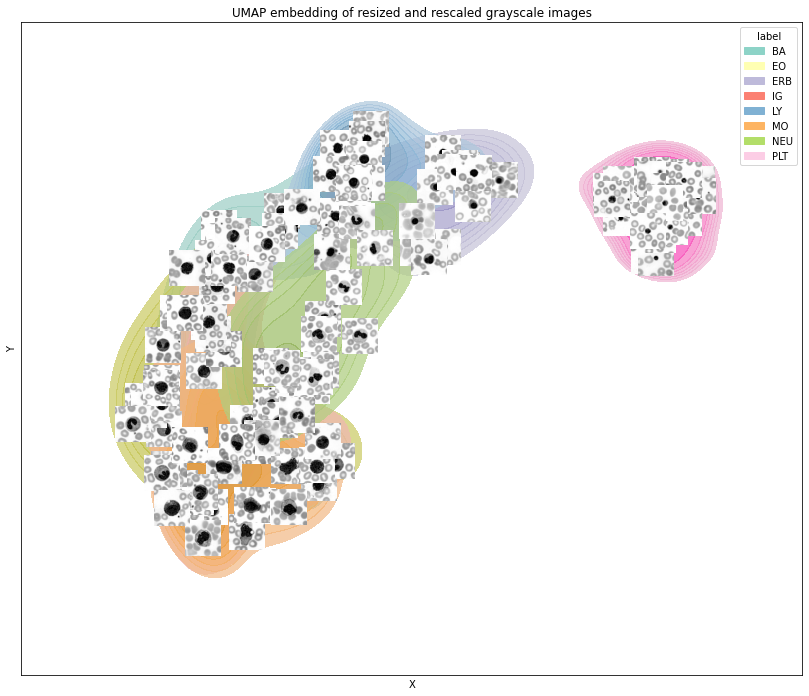

In [19]:
fig, ax = plt.subplots(1, figsize=(14, 12))
sns.kdeplot(x=sample.X, y=sample.Y, hue='label', data=sample, shade=True, thresh=0.2, alpha=0.7, palette='Set3')
plt.setp(ax, xticks=[], yticks=[])

plt.title('UMAP embedding of resized and rescaled grayscale images')


def getImage(path):
    return OffsetImage(leuko.load_image(path, as_grey=True, rescale=0.1),
                      cmap='gray')

for x, y, path in zip(x_coord, y_coord, paths):
    ab = AnnotationBbox(getImage(path), (x, y), frameon=False)
    ax.add_artist(ab)

### Plotting connectivity edge

/home/marie-anne/anaconda3/envs/DStest/lib/python3.9/site-packages/umap/plot.py:854: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

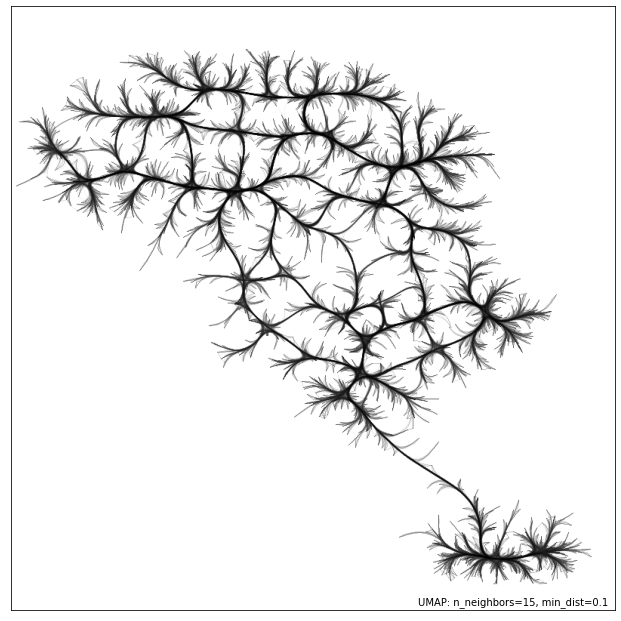

In [20]:
umap.plot.connectivity(mapper_s, edge_bundling='hammer')

## Embedding with label

In [21]:
%%time
embedding_lab = umap.UMAP().fit_transform(images_flat, y=target)

CPU times: user 12min 36s, sys: 6.01 s, total: 12min 42s
Wall time: 2min 19s


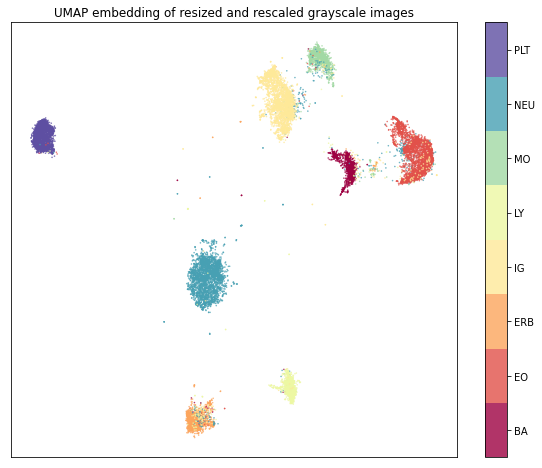

In [22]:
fig, ax = plt.subplots(1, figsize=(10, 8))
plt.scatter(*embedding_lab.T, s=0.3, c=target, cmap='Spectral', alpha=0.8)
plt.setp(ax, xticks=[], yticks=[])

cbar = plt.colorbar(boundaries=np.arange(len(le.classes_)+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(le.classes_)
plt.title('UMAP embedding of resized and rescaled grayscale images');

## Save data

In [26]:
pd.DataFrame(embedding_lab, columns=['UMAP0', 'UMAP1']).to_pickle('../../data/PBC_dataset_normal_UMAP.pkl')